In [1]:
#Code to fit a specific surface distribution to ATL03 photon cloud

#Import modules

import earthaccess
from datetime import datetime
import numpy as np
import is2_model as is2m
import h5py
import pdb  #python debugger
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import interpolate
from scipy.signal import find_peaks, resample, resample_poly
from scipy.optimize import curve_fit

In [2]:
#Input file and beam

ATL03_file = 'ATL03_20220417011336_03811505_006_02.h5'
beam = 'gt1l'

#Define lat/lon box
startlat = 71.30
startlon = -160
endlat = 71.8
endlon = -150

####Retrieval length and window size
segment_length = 500.0 #Length of segment in meters to collect photons
window_size = 3.0 #Size in meters to window the photon data around the mean of segment

#Set options for curve fitting and photon selection
fit_opts = {'ftol': 0.01, 'max_nfev': 500, 'xtol': 0.01}
surface_fitting_method = 'Lognormal'  #'Gaussian' or 'Lognormal'
min_photon_confidence_flag = 3

In [3]:
#####Access data using Earthaccess
earthaccess.login(strategy='interactive', persist=True)
auth = earthaccess.login()

Enter your Earthdata Login username:  nkurtz
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/07/2023
Using user provided credentials for EDL
Persisting credentials to .netrc
We are already authenticated with NASA EDL


In [4]:
results = earthaccess.search_data(
    short_name = 'ATL03',
    version = '006',
    cloud_hosted = True,
    bounding_box = (startlon,startlat,endlon,endlat),
    temporal = ('2022-04-17','2022-04-18'),
    count = 100
)

#[display(r) for r in results]

files = earthaccess.open(results)
ATL03_file = files[0]
ATL03_file

Granules found: 2
 Opening 2 granules, approx size: 7.35 GB


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

<File-like object S3FileSystem, nsidc-cumulus-prod-protected/ATLAS/ATL03/006/2022/04/17/ATL03_20220417011336_03811505_006_02.h5>

In [5]:
#################Read ATL03 file and get photon heights and geophysical corrections################


hf = h5py.File(ATL03_file, 'r')	#Open the file

# Read ATL03 parameters of interest
ph_delta_time = hf[beam + '/heights/delta_time'][:]
ph_track_dist = hf[beam + '/heights/dist_ph_along'][:]
ph_lat = hf[beam + '/heights/lat_ph'][:]
ph_lon = hf[beam + '/heights/lon_ph'][:]
ph_height = hf[beam + '/heights/h_ph'][:]
#geoid = hf[beam + '/geophys_corr/geoid'][:]
ph_confidence = hf[beam + '/heights/signal_conf_ph'][:, 0] #0: land, 1: ocean, 2: sea ice, 3: land ice, 4: inland water
#ph_pulse_id = ATL03file[beam + '/heights/ph_id_pulse'][:]


hf.close()

goodpts =  np.where( (ph_confidence >= min_photon_confidence_flag ) & (ph_lat > startlat) & (ph_lat < endlat ))
npts = np.size(goodpts)
print("Number of photons found: ",npts)


#Reindex to area of interest
ph_delta_time = ph_delta_time[goodpts]
ph_track_dist = ph_track_dist[goodpts]
ph_lat = ph_lat[goodpts]
ph_lon = ph_lon[goodpts]
ph_height = ph_height[goodpts]
#geoid = geoid[goodpts]
ph_confidence = ph_confidence[goodpts]


Number of photons found:  301136


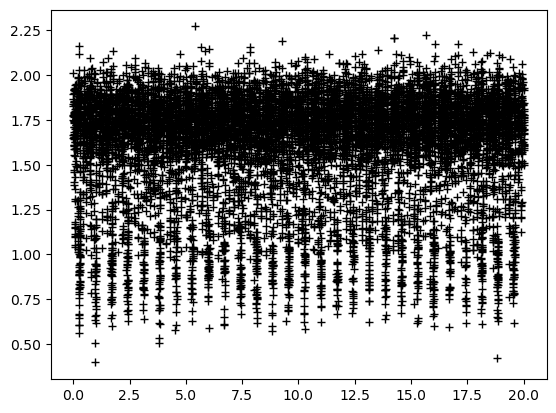

In [6]:
###Plot check of photon cloud
goodpts_plt =  np.where( (ph_confidence >= min_photon_confidence_flag ) & (ph_lat > 71.32) & (ph_lat < 71.33 ))
plt.plot(ph_track_dist[goodpts_plt]-np.min(ph_track_dist[goodpts_plt]),ph_height[goodpts_plt],'+k')	
plt.show()

/home/jovyan/Nathan_surfit/is2_model.py:66: RuntimeWarning: invalid value encountered in log
  surf_pdf = 1/(xgtau*sig_surf*np.sqrt(2*pi)) * np.exp( -1.0*(np.log(xgtau) - mu)**2 / (2*sig_surf**2))  ##log-normal function distribution


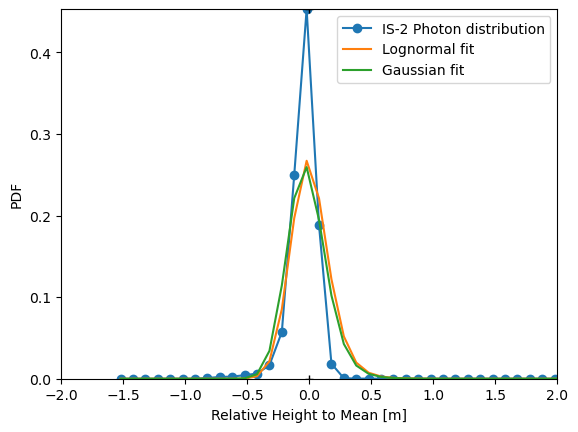

N photons:  6463
Lognormal height retrack correction, lognormal sigma, fit_error:  0.11959047514404511 0.01389661572318069 0.05305347491155599
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.12034543837216193 0.029099018669237343 0.05097096402193149


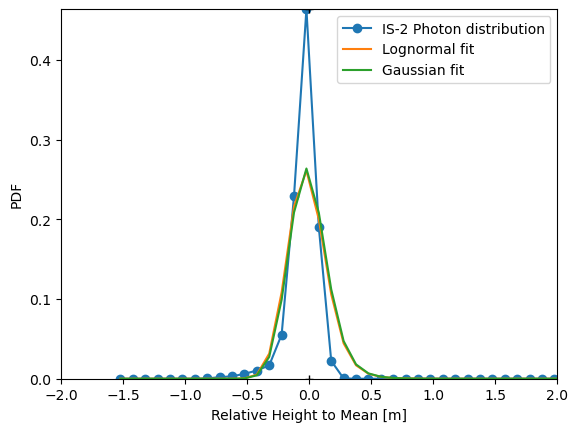

N photons:  6024
Lognormal height retrack correction, lognormal sigma, fit_error:  0.12309657659849364 0.015725322613238907 0.053698034372592365
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.12301162098524597 0.012524015073778368 0.05352465636304435


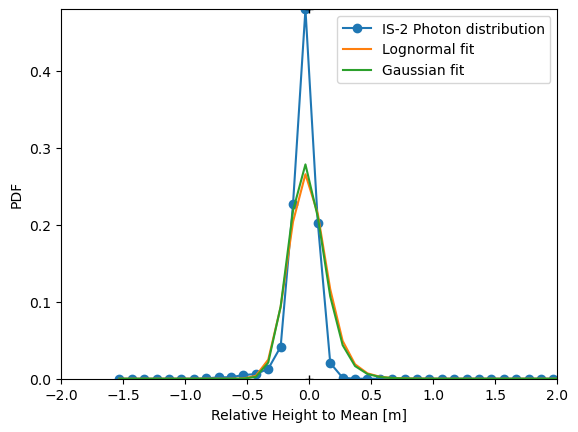

N photons:  7194
Lognormal height retrack correction, lognormal sigma, fit_error:  0.13079208823642804 0.011549161710260313 0.06130770559728185
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.06251187152733652 0.01887379137007887 0.05316228103542243


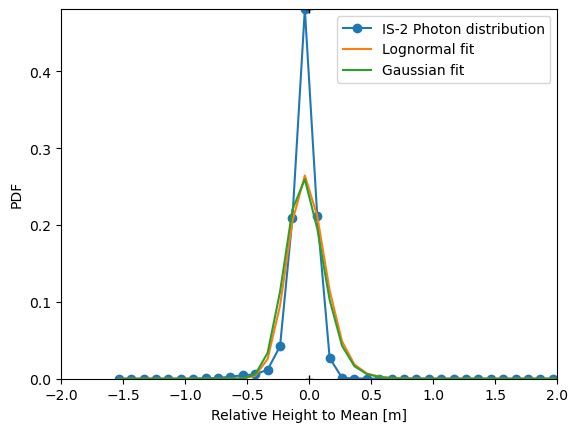

N photons:  7097
Lognormal height retrack correction, lognormal sigma, fit_error:  0.13465930631232184 0.015162705997945156 0.06033851767521747
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.1357108645992801 0.020673483573294415 0.06273016522246146


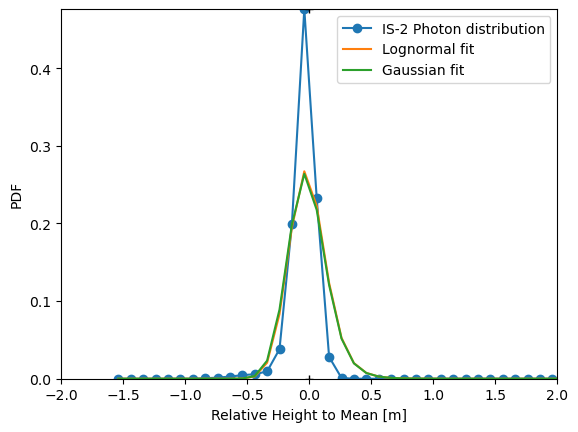

N photons:  7905
Lognormal height retrack correction, lognormal sigma, fit_error:  0.13752803087201393 0.015353065632485079 0.05821651288545325
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.13196670717446193 0.030567199595458717 0.05969978763150759


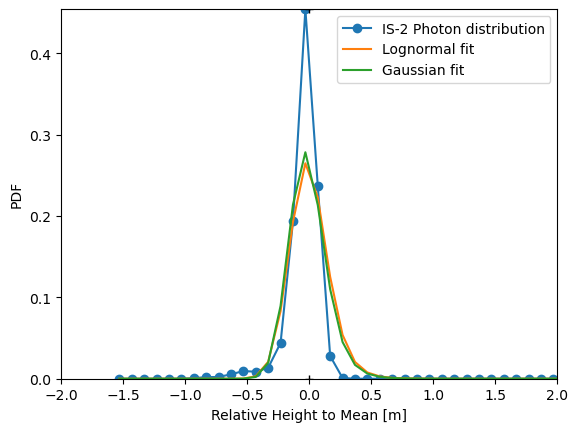

N photons:  7806
Lognormal height retrack correction, lognormal sigma, fit_error:  0.12273684516649638 0.028034793376140087 0.05065678203381611
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.05938435468120164 0.008484833890324447 0.04328562302572401


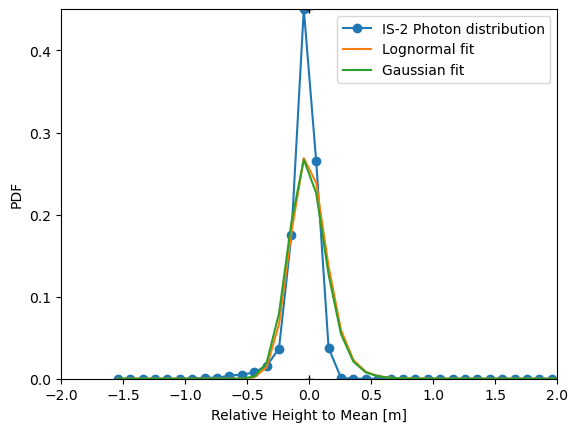

N photons:  7080
Lognormal height retrack correction, lognormal sigma, fit_error:  0.13659824390677397 0.017873226647961996 0.04858118049604416
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.13880031817242044 0.019656492404737585 0.04867182088882707


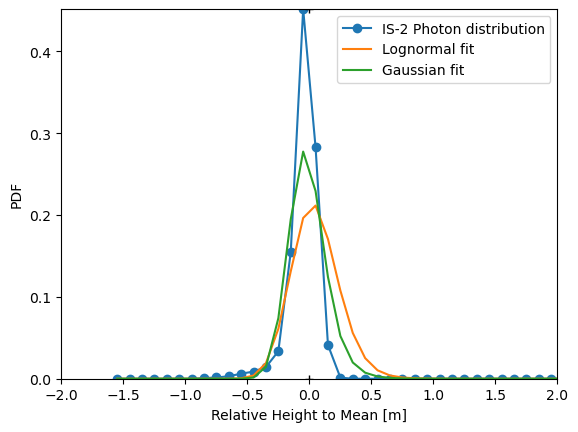

N photons:  6659
Lognormal height retrack correction, lognormal sigma, fit_error:  0.0 0.11480940878391266 0.1035829550331066
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.06168433840210036 0.008650740112724204 0.04642573032388998


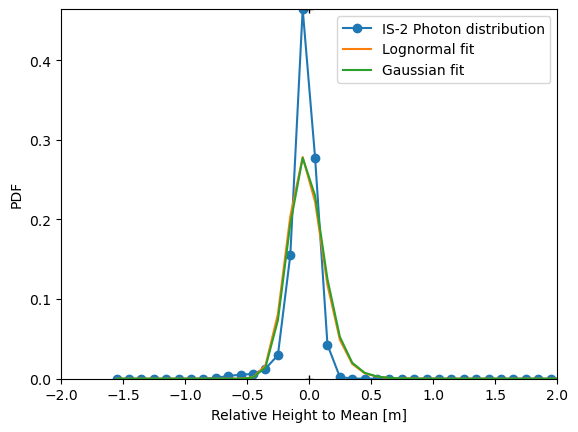

N photons:  7626
Lognormal height retrack correction, lognormal sigma, fit_error:  0.0726500738309183 0.011657366619899013 0.050917542414567515
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.06486001845399576 0.00712524165943071 0.05048870647636877


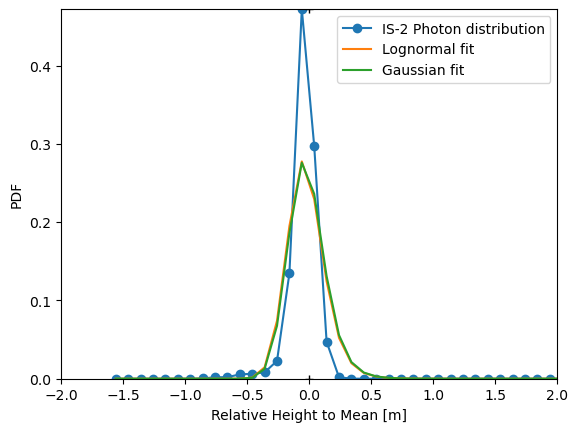

N photons:  8133
Lognormal height retrack correction, lognormal sigma, fit_error:  0.07257177088293225 0.008466130730718948 0.05774979087451226
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.06564718909256188 0.005031746384914063 0.0574126784214186


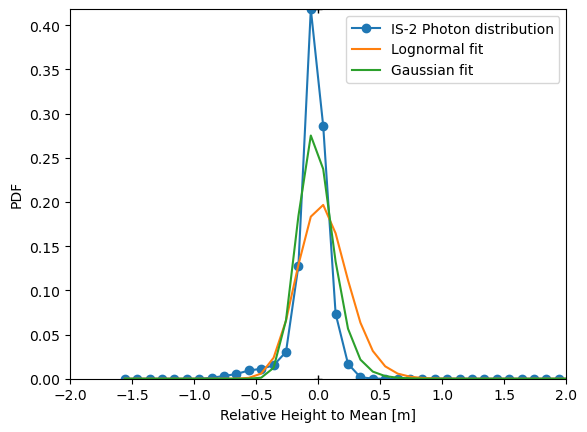

N photons:  6524
Lognormal height retrack correction, lognormal sigma, fit_error:  0.006856383708150257 0.1364827038054751 0.08690043803224251
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.06334816772146035 0.005695643368539275 0.03305659728225352


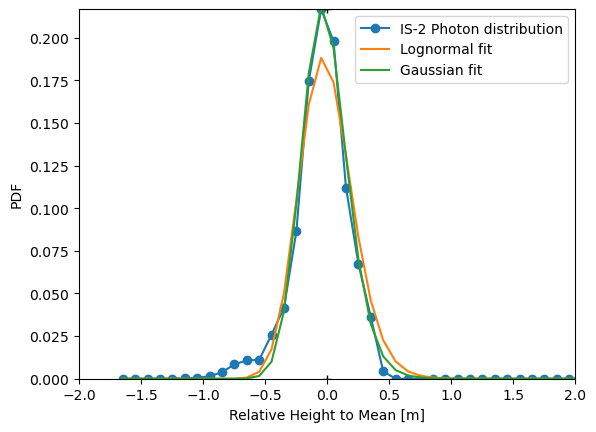

N photons:  3436
Lognormal height retrack correction, lognormal sigma, fit_error:  0.07407665500673842 0.15053208583589073 0.0034653726637545734
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.08019574486095703 0.10749295467353666 0.0013179632754342025


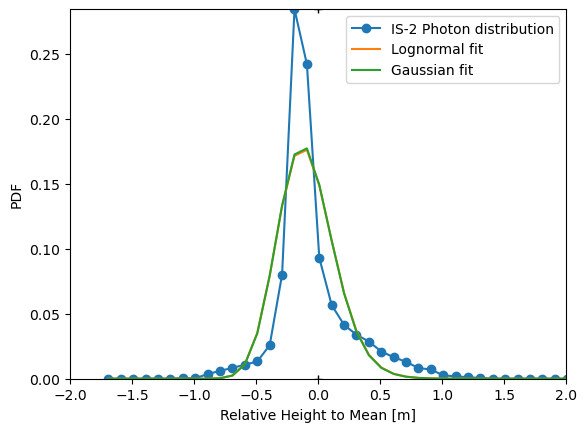

N photons:  6327
Lognormal height retrack correction, lognormal sigma, fit_error:  0.1413548378281206 0.1665673925740507 0.030092570039938586
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.14176953610321827 0.16466401683778004 0.02977098959977745


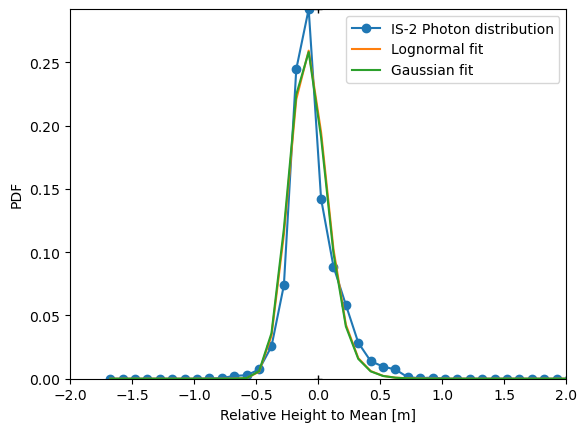

N photons:  4389
Lognormal height retrack correction, lognormal sigma, fit_error:  0.17471838274263637 0.03371166305165091 0.006859172727866634
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.17618071289091886 0.03225135512706753 0.0067713146044380374


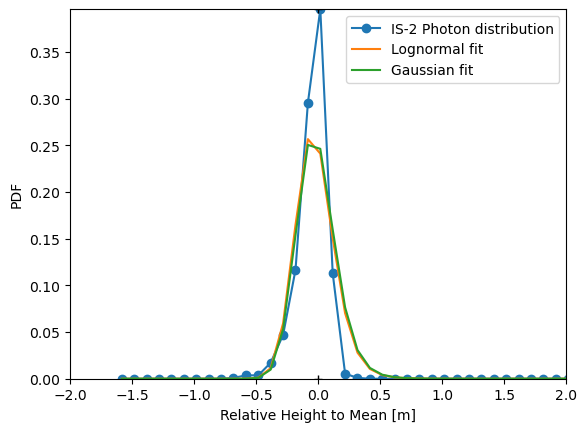

N photons:  1106
Lognormal height retrack correction, lognormal sigma, fit_error:  0.09573667301748887 0.03234986958557115 0.034485573007795284
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.09096850158398552 0.027633900914006408 0.03422578799947


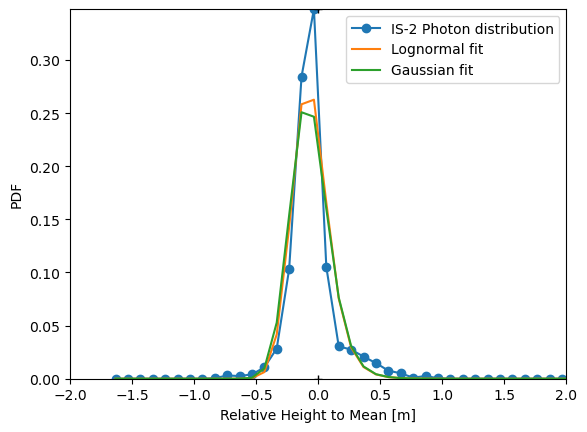

N photons:  1969
Lognormal height retrack correction, lognormal sigma, fit_error:  0.20618875671760642 0.011866718187460011 0.015697143470499105
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.14108631455240422 0.023554128085480994 0.019947671537579127


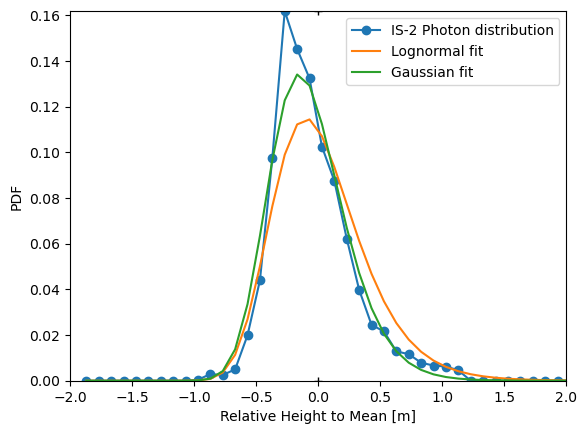

N photons:  2409
Lognormal height retrack correction, lognormal sigma, fit_error:  0.019878223459527382 0.32284159181819055 0.007601706450065731
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.119350604952389 0.259834715934017 0.0026178306127045674


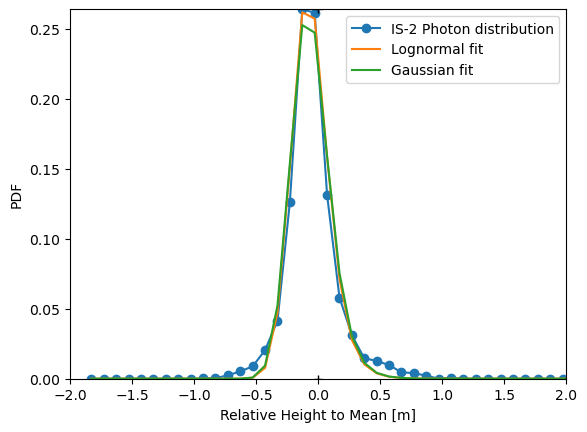

N photons:  4536
Lognormal height retrack correction, lognormal sigma, fit_error:  0.20499512646653706 0.02362041000652122 0.002069519022167818
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.1308097350568878 0.009144459850010743 0.0027089238225678357


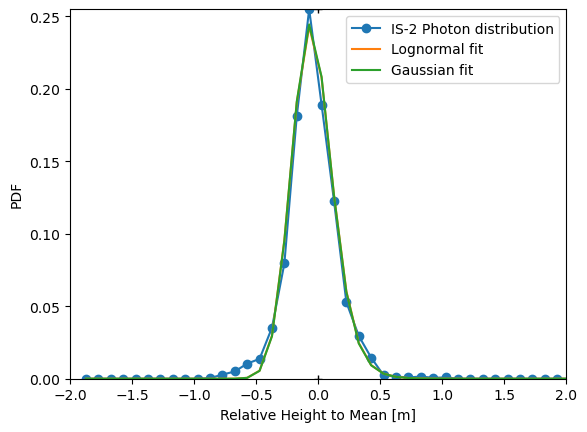

N photons:  4604
Lognormal height retrack correction, lognormal sigma, fit_error:  0.1570301612704659 0.07553773918071413 0.001196622020605641
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.10718113827810823 0.07389990950062858 0.0011804001283034805


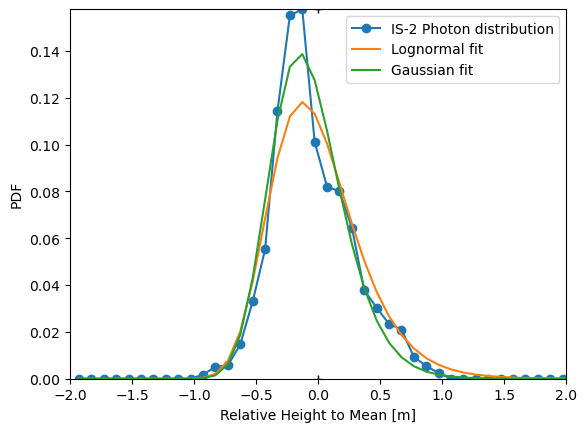

N photons:  3333
Lognormal height retrack correction, lognormal sigma, fit_error:  0.06717121329199803 0.3109132411650075 0.004913878954068828
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.1509260721130539 0.24762951699340693 0.0030177542677971734


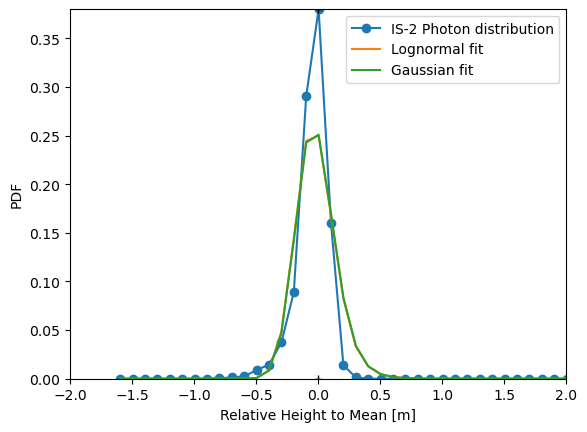

N photons:  1584
Lognormal height retrack correction, lognormal sigma, fit_error:  0.10153911236789165 0.023038153421383607 0.028251095547056813
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.10072698731122975 0.02126502901180732 0.02818490137385769


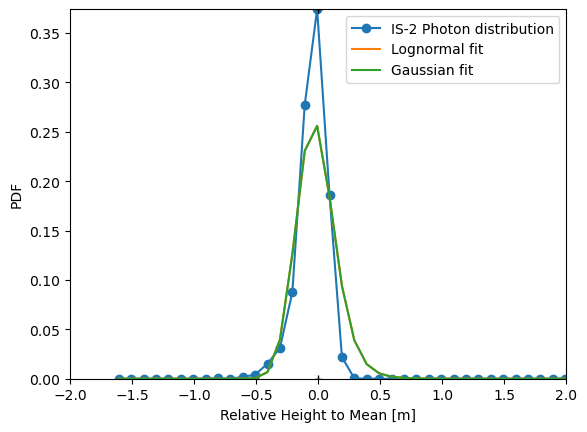

N photons:  2696
Lognormal height retrack correction, lognormal sigma, fit_error:  0.11004337746693198 0.02176812981537473 0.024727594995732384
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.11002001905776956 0.030373814276969443 0.02473822407967498


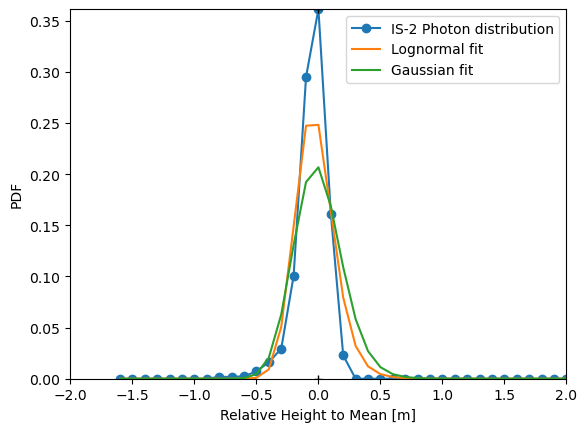

N photons:  1671
Lognormal height retrack correction, lognormal sigma, fit_error:  0.10445937300591085 0.025769396622074482 0.022380309771212997
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.04770962754141547 0.12156923234209713 0.04830884165853452


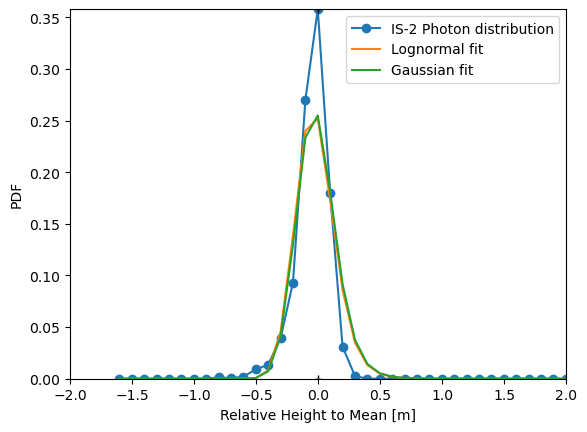

N photons:  1548
Lognormal height retrack correction, lognormal sigma, fit_error:  0.10798994754483036 0.030275085413705424 0.018634870224450213
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.10549525508631838 0.02307402450325642 0.018540089087577795


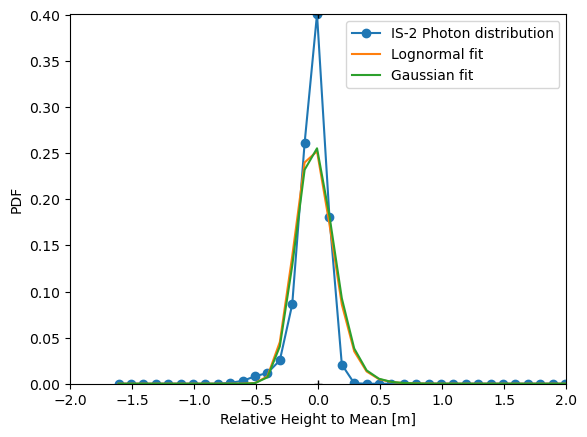

N photons:  1975
Lognormal height retrack correction, lognormal sigma, fit_error:  0.11276685674181952 0.02047198624162229 0.0315308198640449
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.11155135670501737 0.034111021375072326 0.030968133295390825


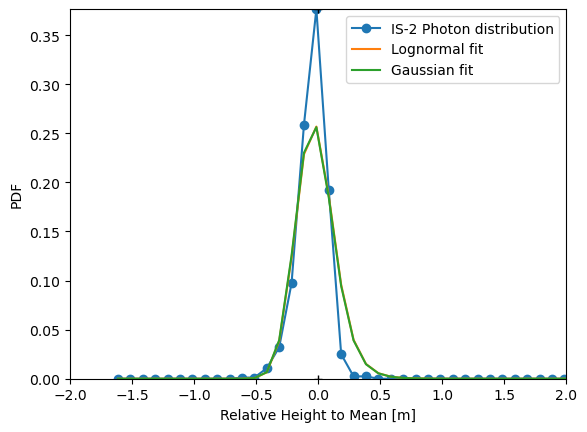

N photons:  842
Lognormal height retrack correction, lognormal sigma, fit_error:  0.11572006736348914 0.024703793119213727 0.022601730089606035
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.11610678583301412 0.021182291855310776 0.022553457003683677


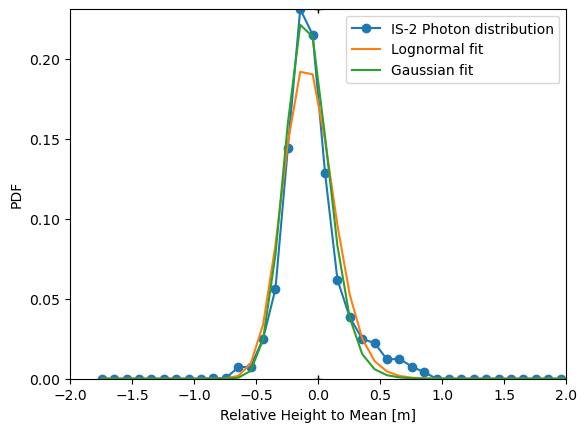

N photons:  2244
Lognormal height retrack correction, lognormal sigma, fit_error:  0.1569415154959343 0.13742246591025586 0.005161680237798166
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.21316237660189372 0.09650687943181283 0.002466461907700074


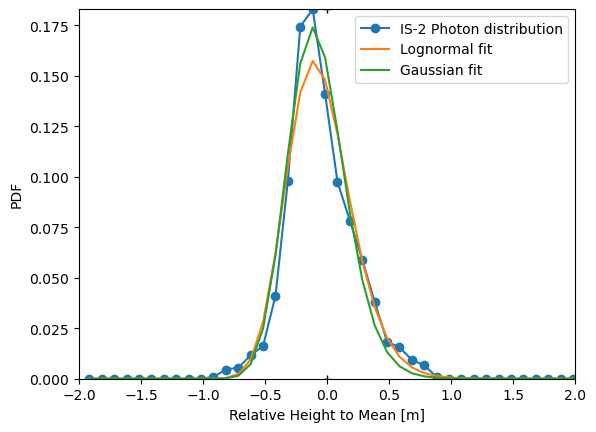

N photons:  4381
Lognormal height retrack correction, lognormal sigma, fit_error:  0.1344195289296178 0.20526325978620316 0.003156268398956445
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.14494442396417861 0.17431251226792419 0.002521187143440618


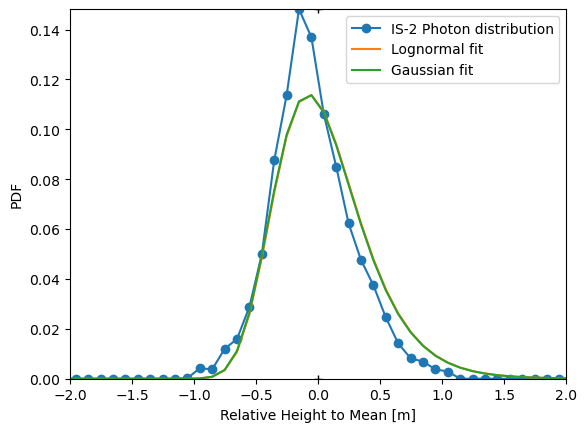

N photons:  4514
Lognormal height retrack correction, lognormal sigma, fit_error:  0.0 0.3262706398963928 0.0036871594345527924
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.001924033967229294 0.32615241952085466 0.0035209895359862194


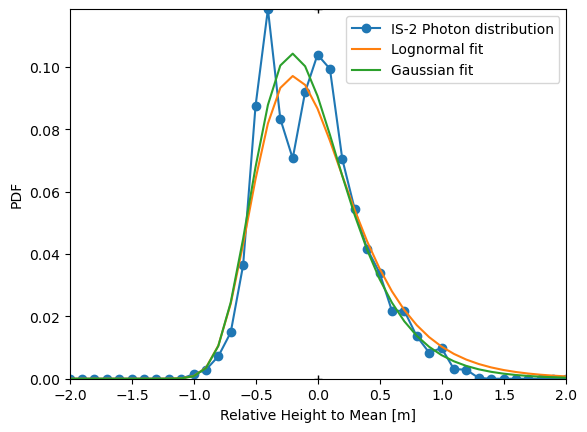

N photons:  4176
Lognormal height retrack correction, lognormal sigma, fit_error:  0.049190573702589405 0.40612736925587645 0.0038687689102450628
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.12258821391597076 0.3684729381111126 0.0037057864782887784


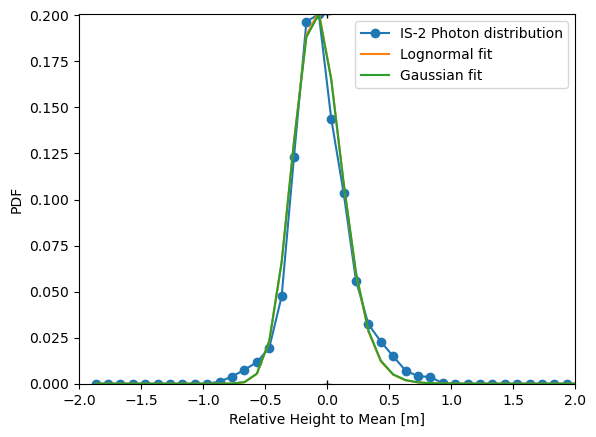

N photons:  4371
Lognormal height retrack correction, lognormal sigma, fit_error:  0.11639535294727957 0.12813203446967222 0.0013681032689774142
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.16610365786926978 0.13016040400180193 0.0013653151155169538


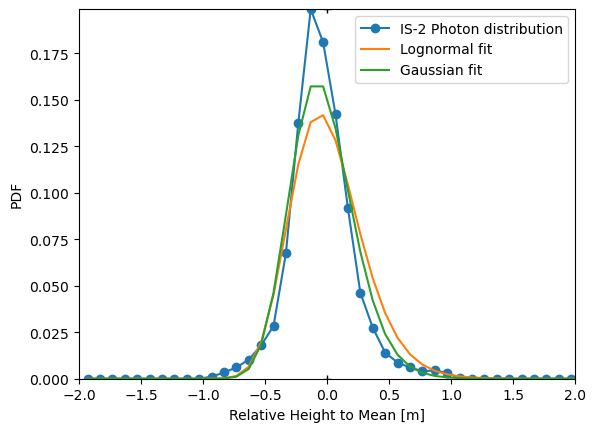

N photons:  4474
Lognormal height retrack correction, lognormal sigma, fit_error:  0.06228258145452972 0.23853405836171246 0.008966605528155876
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.08212833672786958 0.19929033400110638 0.004111476894063496


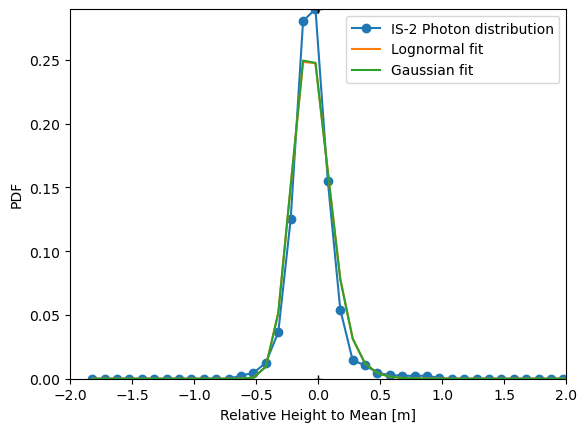

N photons:  4559
Lognormal height retrack correction, lognormal sigma, fit_error:  0.13004497802502074 0.03112095881408986 0.004717690919606724
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.12742265761259583 0.021027651127247405 0.004605585725866242


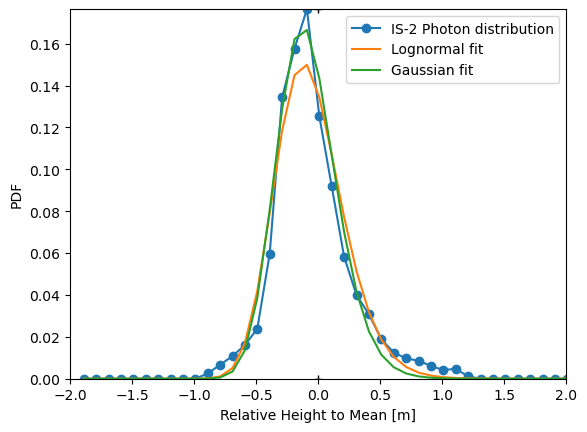

N photons:  3604
Lognormal height retrack correction, lognormal sigma, fit_error:  0.12558787913779684 0.21955723316207174 0.0028051676687195076
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.13753764197208435 0.18406806328798986 0.0019494600459512693


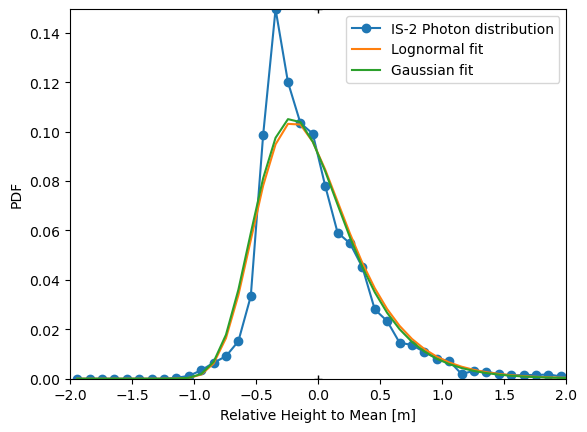

N photons:  5274
Lognormal height retrack correction, lognormal sigma, fit_error:  0.0847153971442761 0.3696589845760626 0.005021477220582782
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.0939399667856701 0.3623139517056762 0.004691797919439573


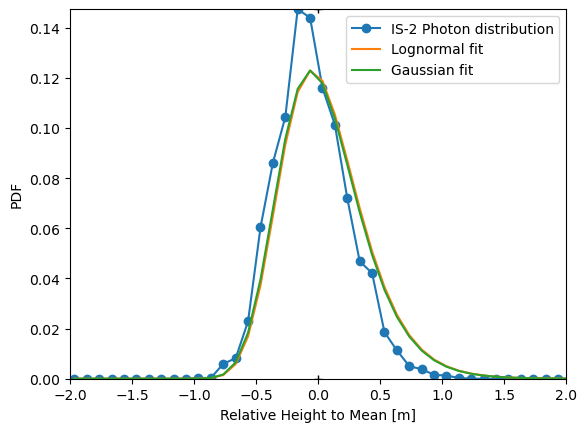

N photons:  3181
Lognormal height retrack correction, lognormal sigma, fit_error:  0.004288960267143477 0.2940080254439117 0.0042960778011895346
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.008849190058497903 0.2941759424106192 0.0036836639440028032


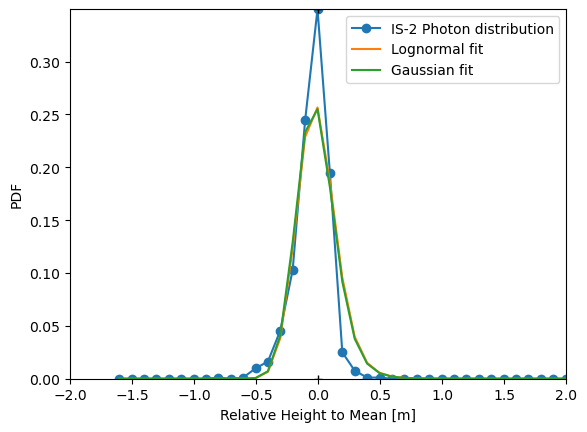

N photons:  921
Lognormal height retrack correction, lognormal sigma, fit_error:  0.10626183107730473 0.03689576431683555 0.015854765983547268
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.10771382105526596 0.024828500048236266 0.015695345497291593


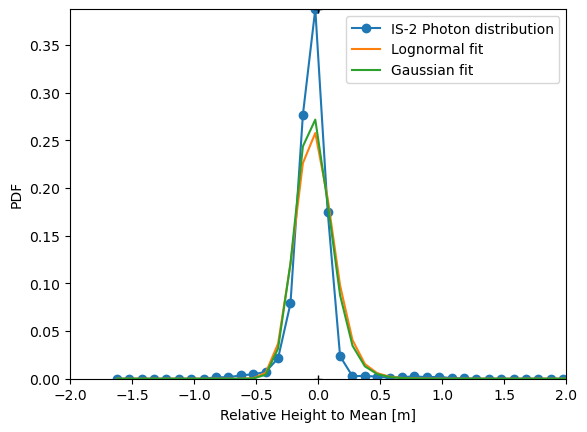

N photons:  1950
Lognormal height retrack correction, lognormal sigma, fit_error:  0.12375852651945632 0.026942597622928416 0.02878398145309445
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.17828442902845257 0.0065239890712256755 0.02178532435972454


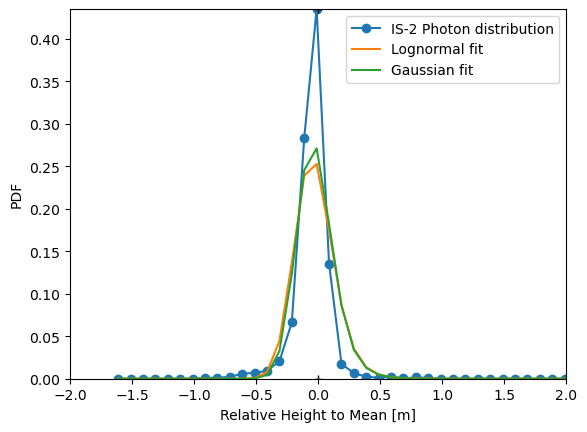

N photons:  4752
Lognormal height retrack correction, lognormal sigma, fit_error:  0.11577862268178135 0.022144906689311593 0.04809580850377636
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.16907571958080847 0.005029631927402831 0.039549621164580114


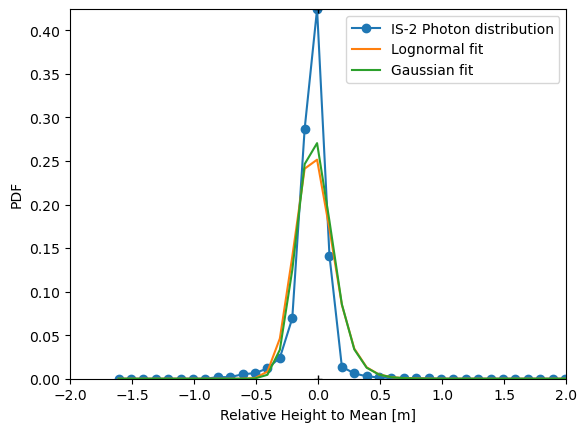

N photons:  3285
Lognormal height retrack correction, lognormal sigma, fit_error:  0.11378300464118643 0.027740339395678965 0.04449169100668019
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.16676709355020147 0.005459145932678804 0.03618962531048023


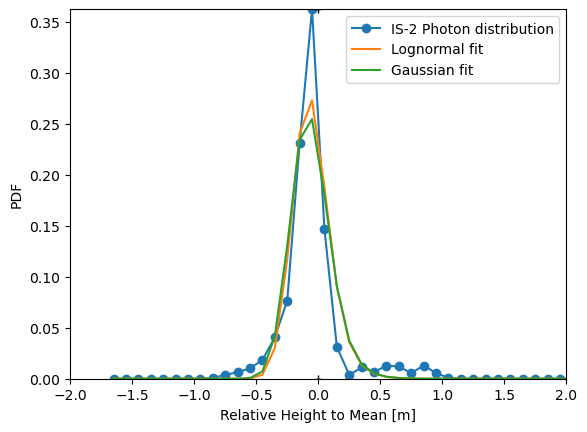

N photons:  1084
Lognormal height retrack correction, lognormal sigma, fit_error:  0.20130813977584952 0.021053106122524985 0.016840641165818106
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.1513154588146177 0.012561423889543207 0.02113052375372773


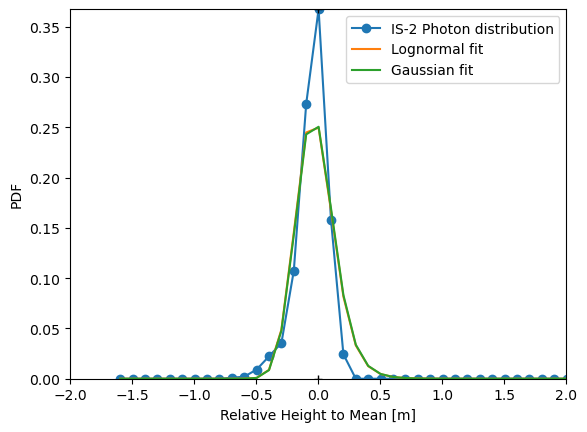

N photons:  988
Lognormal height retrack correction, lognormal sigma, fit_error:  0.10277237781284838 0.028286301986287926 0.021227067531895454
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.10278576590038964 0.031809024569332225 0.02121670695036047


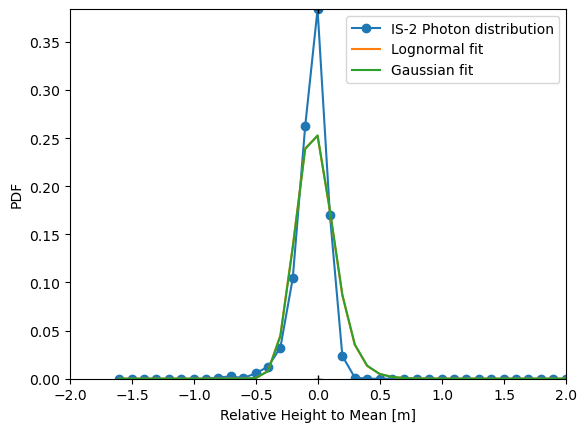

N photons:  1609
Lognormal height retrack correction, lognormal sigma, fit_error:  0.10904946784708154 0.025975483262398954 0.024531135774728655
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.10800522838727039 0.01973829896179332 0.024482471042883217


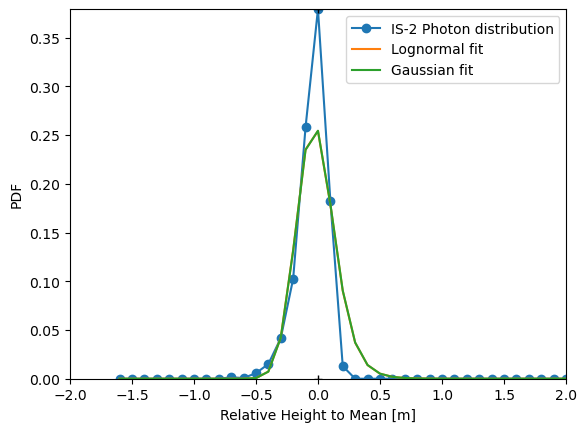

N photons:  1395
Lognormal height retrack correction, lognormal sigma, fit_error:  0.10462209483178676 0.024679657200757342 0.024671082349630436
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.10425757290582086 0.020924840904842947 0.024680247708862034


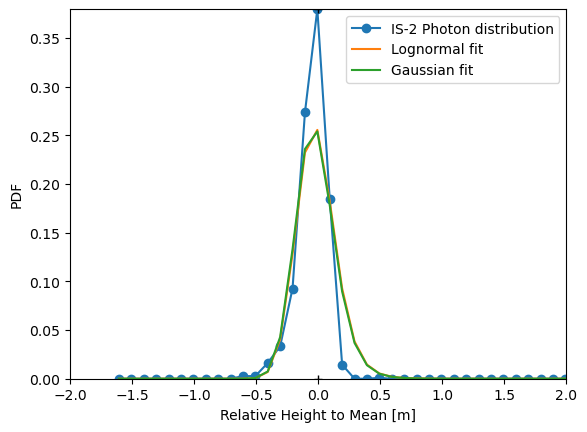

N photons:  1112
Lognormal height retrack correction, lognormal sigma, fit_error:  0.10872037721537126 0.021165882505848343 0.026312692775024574
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.11015169973685676 0.030161905938007594 0.026227062348784323


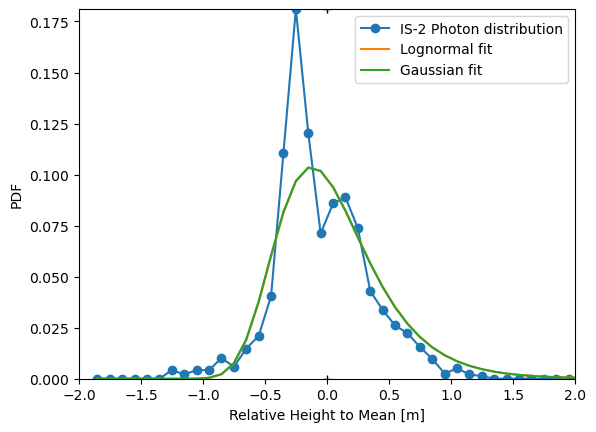

N photons:  2375
Lognormal height retrack correction, lognormal sigma, fit_error:  0.0 0.37122008204460144 0.010777799013150822
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.001679429801363652 0.370952325110041 0.010687990705664065


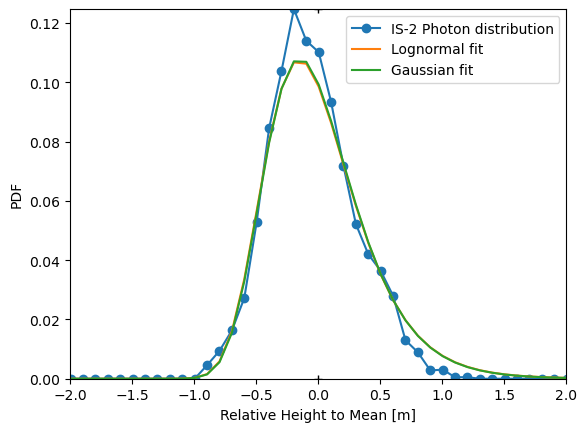

N photons:  3930
Lognormal height retrack correction, lognormal sigma, fit_error:  0.045477404845288845 0.35311222963332384 0.0009712177461850062
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.04488024110150982 0.3509285536973203 0.00092084623518832


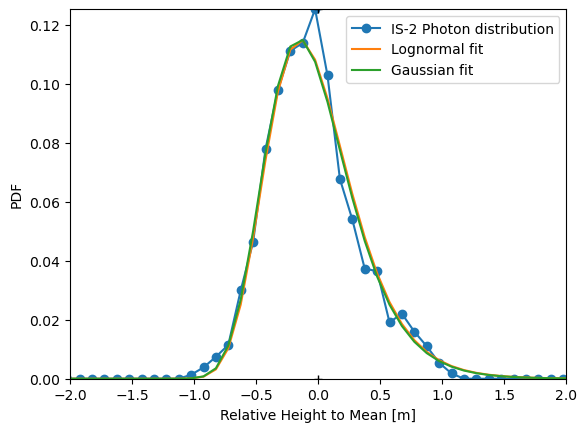

N photons:  4445
Lognormal height retrack correction, lognormal sigma, fit_error:  0.07047699167945294 0.32262841093287936 0.0008377235025770304
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.07550992071729626 0.3213433258663495 0.0007863953944182022


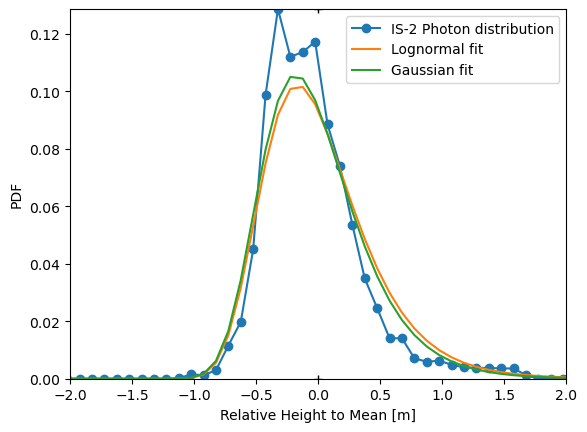

N photons:  4760
Lognormal height retrack correction, lognormal sigma, fit_error:  0.05478533855691227 0.37886899442864763 0.0038514175504115768
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.07115915705131007 0.3614411218813429 0.0029334728251075005


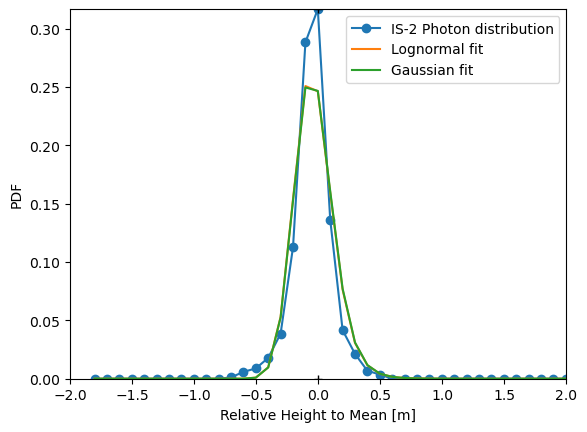

N photons:  4422
Lognormal height retrack correction, lognormal sigma, fit_error:  0.11022730569320546 0.02497648540757503 0.010285415054415405
Gaussian height retrack correction, Gaussian sigma, fit_error:  0.111031859214198 0.028795976828046806 0.010339573295599824


In [7]:
##For each segment fit the surface height distribution and plot

min_dtime = ph_delta_time[0]
for ngood in range(0,50):  #npts-1
    
    max_dtime = min_dtime + segment_length/6900.0  #Assumes a constant orbital speed and converted to length of segment

    init_ph_loc = np.where( (ph_delta_time >= min_dtime) & (ph_delta_time < max_dtime) )
    coarse_ph_mean = np.mean(ph_height[init_ph_loc])
    photons_loc = np.where( (ph_delta_time >= min_dtime) & (ph_delta_time < max_dtime) & ( ph_height > (ph_height-window_size) ) & ( ph_height < (ph_height+window_size)) )
    ph_mean = np.mean(ph_height[photons_loc])
    ph_std = np.std(ph_height[photons_loc])
    
    #plt.plot(ph_delta_time[photons_loc],ph_height[photons_loc]-ph_mean,'+k')
    #plt.show()
    
    
    nrb = 70
    rb_res = 0.1
    track_point = ph_mean
    range_bins_m = np.arange(1, nrb) * rb_res - (nrb-1)/2*rb_res - ph_mean #(nrb-1)/3*rb_res  # Set range bins with 3 cm resolution
    wf = np.histogram(ph_height[photons_loc]-ph_mean,bins=range_bins_m)
    #WF_norm_this = wf[0][:]/np.max(wf[0][:])
    WF_norm_this = wf[0][:]/np.sum(wf[0][:])
    WF_norm_this[WF_norm_this < 0] = 0
    wf_rb = wf[1][:]
    
    
    # Calculate lognormal or Gaussian fit

    range_bins_m_hr = np.arange(1, nrb*5) * rb_res/5 - (5*nrb-1)/2*rb_res/5 - ph_mean  # Set range bins with 5x rb_res cm resolution for use when generating pulse shape and distributions
    range_bins_unit = np.arange(1, nrb)

    tracker = lambda xdata, *p: is2m.is2modelfit_nonnormalized(xdata, p,range_bins_m_hr)

    rb_use = range_bins_m[0:np.size(WF_norm_this)]
    
    if surface_fitting_method == 'Lognormal':  
        fit_method = 1
    if surface_fitting_method == 'Gaussian':
        fit_method = 0
    
    
    x0 = np.asarray([fit_method, 0, ph_std])  # Fit method, x shift (in meters), roughness
    lb = x0 - [0.05, 0.5, 0.3]
    ub = x0 + [0.05, 0.5, 0.3]
    if lb[2] < 0:
        lb[2] = 0.005
    GSFC_optimal, GSFC_cov = curve_fit(tracker, rb_use, WF_norm_this, x0, bounds=(lb, ub), method='trf',  **fit_opts)


    GSFC_fit = is2m.is2modelfit_nonnormalized(rb_use, GSFC_optimal,range_bins_m_hr)
    # Calculate sum of squared residuals
    GSFC_resnorm = np.sum((WF_norm_this - GSFC_fit)**2)
    
    
    #####Run again with Gaussian fit
    x0g = np.asarray([0, 0, ph_std])  # Fit method, x shift (in meters), roughness
    lb[0]=0
    ub[0] = 1
    GSFC_optimal_Gaussian, GSFC_cov_Gaussian = curve_fit(tracker, rb_use, WF_norm_this, x0g, bounds=(lb, ub), method='trf',  **fit_opts)
    GSFC_fit_Gaussian = is2m.is2modelfit_nonnormalized(rb_use, GSFC_optimal_Gaussian,range_bins_m_hr)
    # Calculate sum of squared residuals
    GSFC_resnorm_Gaussian = np.sum((WF_norm_this - GSFC_fit_Gaussian)**2)
    
    
    #dual_Gaussian_fit = weight1*1/(np.sqrt(2*np.pi)*w1) * np.exp(-0.5*(xin-m1)**2/(w1)**2) + weight2*1/(np.sqrt(2*np.pi)*w2) * np.exp(-0.5*(xin-m2)**2/(w2)**2)
    #dual_Gaussian_fit = dual_Gaussian_fit/np.max(dual_Gaussian_fit)
    #surf_pdf = dual_Gaussian_fit
    ####Generate IS-2 transmit pulse shape and convolve with Gaussian
    #mu = 0.0
    #sigma = 0.116767  #sigma of Gaussian in meters  
    #tau = 9.92750  #exponential relaxation time in meters
    #xin = wf_rb[0:np.size(wf[0][:])]
    #taufit_hr = xin
    #taufit = xin
    ##Convert range bin times to x values in meters with mean of x at tau=0
    #mean_xmg = mu + 1/tau
    #xmgtau = taufit_hr + mean_xmg
    #yy = tau/2*np.exp(tau/2*(2*mu + tau*sigma**2 - 2*xmgtau))*scipy.special.erfc( (mu + tau*sigma**2 - xmgtau) / (np.sqrt(2)*sigma) )

    
    #power = np.convolve(surf_pdf,yy)
    ## Change axis size after convolution
    #Taxis=np.arange(0,len(power))*(taufit[1]-taufit[0]) + taufit[0]*2

    ##  Get convolved power matrix to same size as input
    #startloc = np.argmin(np.abs(Taxis - taufit[0])) # finds location of taufit start on Taxis
    #power_final = power[startloc:startloc+len(taufit)]

    ##  normalize, remove negative values
    #power_final = power_final/np.max(power_final)
    #power_final[power_final < 0] = 0
    #dual_Gaussian_fit = power_final / np.max(power_final)
    #####################################
    
    p1b,=plt.plot(wf_rb[0:np.size(wf[0][:])],WF_norm_this,'-o',label='IS-2 Photon distribution')
    
    p1a,=plt.plot(rb_use,GSFC_fit,label=surface_fitting_method + ' fit')
    
    p1c,=plt.plot(rb_use,GSFC_fit_Gaussian,label='Gaussian fit')
    
    #p2=plt.plot(rb_use+GSFC_optimal[1],WF_norm_this,'k')
    p2 = plt.plot([0,0],[0,np.max(WF_norm_this)],'+k') #Plot 0 point which is the mean height location
    #p1 = plt.plot([1.0*GSFC_optimal[1],1.0*GSFC_optimal[1]],[0,1])  #Plot Ron's ATL07 tracking point
    plt.legend(handles=[p1b, p1a, p1c])
    plt.axis([-2, 2, 0, np.max(WF_norm_this)]) 
    plt.xlabel('Relative Height to Mean [m]')
    plt.ylabel('PDF')
    plt.show()
    
    print("N photons: ",np.size(photons_loc))
    print("Lognormal height retrack correction, lognormal sigma, fit_error: ",GSFC_optimal[1],GSFC_optimal[2], GSFC_resnorm)
    print("Gaussian height retrack correction, Gaussian sigma, fit_error: ",GSFC_optimal_Gaussian[1],GSFC_optimal_Gaussian[2], GSFC_resnorm_Gaussian)
          

       
    #pdb.set_trace()
    
    min_dtime = max_dtime #Move segment forward